#Uso de series difusas para el desarrollo de modelos de predicción de demandas de la energía eléctrica.

**Estudiante: José Manuel Rubio Cienfuegos.**

**Prof. José Miguel Rubio León.**

**Prof coguía: Francisco Rivera.**

El siguiente notebook contiene el sistema encargado de procesar la base de datos que contiene información sobre diversos consumos de energía, además de datos sobre las variables que afectan este consumo de energía.

##Librerías

Esta celda contiene información sobre todas librerías necesarias para el procesamiento de la información y exposición de los resultados obtenidos.

In [1]:
# Procesamiento de datos y gráficos.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelos de ML clásicos.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.statespace import sarimax
import statsmodels.api as sm

# Métricas
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error

# MAPE Function

def MAPE(y_true, y_pred):
  true_length, pred_length = y_true.__len__(), y_pred.__len__()
  assert true_length == pred_length, ('Lengths of arrays are differents, y_true have ' + str(true_length) + ' values and y_pred have ' + str(pred_length) + ' values.')
  return (100*(sum(abs((y_true - y_pred)/(y_true)))))/(y_true.__len__())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!git clone https://github.com/JossRubio/Prediccion_demanda_energetica

Cloning into 'Prediccion_demanda_energetica'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


##Carga de datos

Los datos a utilizar se cargan en este bloque. Previo a esto se deben haber subido a la interfaz de colab o habilitar un link de algun servidor para cargarlos de manera remota. En el siguiente bloque se pueden subir los archivos de forma local

Con los archivos subidos, entonces se cargan dentro del notebook

In [3]:
# Extracción de datasets

directory = "Prediccion_demanda_energetica/data/"

df_energy = pd.read_csv(directory + "energy_dataset.csv")
df_weather = pd.read_csv(directory + "weather_features.csv")

In [4]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Antes de desarrollar algun modelo, se debe destacar que dentro de los datos ya se cuentan con valores predichos para la demanda. Por ello esta celda indica cual es el **MAPE** (*Mean Absolute Percentage Error*) de los datos pronosticados guardados en el dataset *energy_dataset.csv*

In [6]:
df_demand = df_energy[['total load actual', 'total load forecast']].dropna() # Eliminación de nans presentes en la columna de valores de la demanda.
demand_total, demand_forecast = df_demand['total load actual'], df_demand['total load forecast']

# MAPE de los valores predichos en la demanda del dataset original.
MAPE_goal = MAPE(demand_total.values, demand_forecast.values)
print('The MAPE of the work is:', round(MAPE_goal, 3), '%') 

The MAPE of the work is: 1.096 %


In [7]:
df_energy.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [8]:
''' ANALIZAR SI LOS VALORES DE GENERACIÓN DE DISTINTOS TIPOS DE ENERGÍA EQUIVALE A LA DEMANDA TOTAL MOSTRADA EN EL DATASET. '''
# Suma de valores de la columna del dataset de energia (energy_dataset.csv)

# En primer lugar se quieren eliminar aquellas columnas que en su mayoría poseen valores nans. Para ello se diseña la siguiente función

def nans_remove(df, nan_threshold, reset_index=True):
  df_process = df.copy()
  assert nan_threshold < 1 and nan_threshold > 0 , ('nan threshold must be between 0 and 1')
  cols_names = df.columns
  # print(cols_names)
  for name in cols_names:
    len, drop_len = df_process[name].__len__(), df_process[name].dropna().__len__()
    difference_reason = (len - drop_len)/(len)
    # print(difference_reason)
    if difference_reason > (1-nan_threshold):
      # print(name)
      df_process.drop(columns=[name], inplace=True)
    else:
      continue
  df_process.dropna(inplace=True)
  df_process.reset_index(drop=reset_index, inplace=reset_index)
  return df_process

nan_limit = .9

# Eliminando las columnas nans del dataframe se tiene.
df_energy_processed = nans_remove(df_energy, nan_limit)

# Obteniendo las columnas que solo poseen valores de generación
columns_drop = ['forecast solar day ahead', 'forecast wind onshore day ahead','price day ahead', 'price actual']
columns_demand = ['total load forecast','total load actual']
demand_data, time_data = df_energy_processed[columns_demand], df_energy_processed['time']

df_generation = df_energy_processed.drop(columns=columns_drop + columns_demand)
generation_values = df_generation.values

# Sumando los valores numericos del dataframe procesado, y añadiendo la columna al dataframe original
generation_total = df_generation.sum(axis=1, numeric_only=True)
generation_total.name = 'Generation total'

df_gen_dem = pd.concat([time_data, generation_total, demand_data], axis=1)
# df_gen_dem.set_index('time', inplace=True)
df_gen_dem.head()

,time,Generation total,total load forecast,total load actual
0,2015-01-01 00:00:00+01:00,28251.0,26118.0,25385.0
1,2015-01-01 01:00:00+01:00,27818.0,24934.0,24382.0
2,2015-01-01 02:00:00+01:00,26796.0,23515.0,22734.0
3,2015-01-01 03:00:00+01:00,25223.0,22642.0,21286.0
4,2015-01-01 04:00:00+01:00,24620.0,21785.0,20264.0


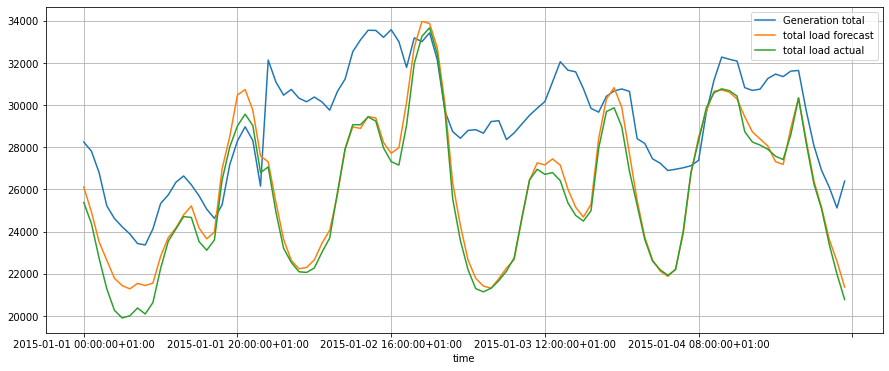

In [9]:
df_gen_dem.iloc[:100].plot(x='time', figsize=(15,6), grid=True)

In [10]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [11]:
energy_values = df_energy.values
generation_values, demand_values = energy_values[:,1:-7], demand_total.values
generation_values.shape

(35064, 21)

In [12]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [13]:
generation_values

array([[447.0, 329.0, 0.0, ..., 196.0, 0.0, 6378.0],
       [449.0, 328.0, 0.0, ..., 195.0, 0.0, 5890.0],
       [448.0, 323.0, 0.0, ..., 196.0, 0.0, 5461.0],
       ...,
       [292.0, 0.0, 0.0, ..., 286.0, 0.0, 3503.0],
       [293.0, 0.0, 0.0, ..., 287.0, 0.0, 3586.0],
       [290.0, 0.0, 0.0, ..., 287.0, 0.0, 3651.0]], dtype=object)

## Extracción de variables estocásticas de interes para la demanda de la energía eléctrica.

Una parte importante de este trabajo es la búsqueda de las características que más afectan a la demanda de la energía eléctrica, donde se espera que estas esten presentes dentro de la base de datos. Para ellos se realiza una búsqueda de cuales son las variables que más influyen en los valores presentes en la demanda de la energía.

En primer lugar se realizará un análisis inmediato sobre las generaciones en el dataset que contiene la demanda

In [14]:
df_gen_dem.head()

,time,Generation total,total load forecast,total load actual
0,2015-01-01 00:00:00+01:00,28251.0,26118.0,25385.0
1,2015-01-01 01:00:00+01:00,27818.0,24934.0,24382.0
2,2015-01-01 02:00:00+01:00,26796.0,23515.0,22734.0
3,2015-01-01 03:00:00+01:00,25223.0,22642.0,21286.0
4,2015-01-01 04:00:00+01:00,24620.0,21785.0,20264.0


## Series Temporales

En esta sección se procesa la información de la base de datos para realizar las predicciones mediante el uso de series temporales clásicas.

In [15]:
# Procesamiento de la data para el uso de regresores clásicos de ML.

demand_serie = df_gen_dem[['time', 'total load forecast', 'total load actual']]

# Función para la generación de series temporales, cuyo largo se puede configurar.

def series_constructor(df, len_serie, column_serie, column_concat_name=None, dropna=True, reset_index=True):
  df_process = df[column_serie]
  df_out = pd.DataFrame() if column_concat_name == None else df[column_concat_name]
  for k in reversed(range(len_serie + 1)):
    serie_moved = df_process.shift(k)
    serie_moved.name = 't-' + str(k)
    df_out = pd.concat([df_out, serie_moved], axis=1)
  df_out.rename(columns={'t-0':'t'}, inplace=True)
  columns_final = list(df_out.columns) if column_concat_name == None else list(df_out.columns)[1:] + [column_concat_name]
  df_out = df_out[columns_final]
  df_out.dropna(inplace=dropna)
  df_out.reset_index(drop=reset_index, inplace=reset_index)
  return df_out

# Procesamiento de la información de la demanda con la función anterior

length_serie = 24       # Como la serie temporal corresponde a la demanda horaria, entonces el largo será 24.  
demand_time_series = series_constructor(demand_serie, length_serie, column_serie='total load actual', column_concat_name='time')  # Aplicando la función anterior.
demand_series, data_time = demand_time_series.drop(['time'], axis=1), demand_time_series['time']  # Separando la información en las series y datos del tiempo.

forecast_default = demand_serie[['time','total load forecast']]

# Dataframes para el procesamiento de datos

X_data, y_data = demand_series.drop(['t'], axis=1), demand_series['t']

# Datos a utilizar para modelo ARIMA.

# ARIMA_data = df_gen_dem[['time', 'total load actual']]

### Modelos clásicos de ML.

En estas celdas se presentan el desarrollo de regresores clásicos de machine learning, para lo cual se utiliza la librería sklearn para su configuración básica.

In [16]:
# Separación de datos en conjuntos de entrenamiento y validación.
train_size = .7

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_size, shuffle=False)

# Configuración de regresores (sin tuneo) Red Neuronal y Random Forest.
mlp_regressor = MLPRegressor()
rf_regressor = RandomForestRegressor()

# Configuración de modelo ARIMA
# p = 1
# d = 1
# q = 0
# train_length = int(ARIMA_data.__len__()*train_size)

# ARIMA_train, ARIMA_test = ARIMA_data.iloc[:train_length], ARIMA_data.iloc[train_length:]

# arima_model = sm.tsa.statespace.SARIMAX(ARIMA_train['total load actual'], order=(p,d,q), seasonal_order=(1,1,1,24))

# Realizando las predicciones con los modelos clásicos.
mlp_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)

# Entrenamiento de modelo ARIMA
# arima_fit = arima_model.fit()
# arima_fit.summary()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
# Calculo de predicciones y resultados obtenidos por MAPE.
mlp_predictions = mlp_regressor.predict(X_test)
rf_predictions = rf_regressor.predict(X_test)

# Predicciones ARIMA
# arima_predictions = arima_fit.predict(start=ARIMA_train.__len__()+1, end=ARIMA_data.__len__(), dynamic=True)

predictions_array = np.c_[mlp_predictions, rf_predictions]

###Comparación de resultados

Los datos originales poseen predicciones ya realizadas anteriormente, por ende en esta celda se tiene una comparación de estas predicciones vs los resultados obtenidos por los modelos tradicionales de ML.

In [18]:
# Añadiendo las fechas de los resultados obtenidos
index_test = y_test.index

# Creando un DataFrame con los datos de las predicciones realizadas por los regresores
predictions_df = pd.DataFrame(data=predictions_array, columns=['mlp_pred','rf_pred'], index=index_test)


predictions_dates = pd.concat([data_time.iloc[index_test], predictions_df], axis=1)
# predictions_dates

# Realizando un join con los datos forecast del dataset original.
df_comparison = pd.merge(predictions_dates, demand_serie, on='time')
df_comparison.index = index_test

# Printeando los valores MAPE para cada predicción obtenida.

data_real = df_comparison['total load actual']
MLP_pred = df_comparison['mlp_pred']
RF_pred = df_comparison['rf_pred']
default_pred = df_comparison['total load forecast']

print('MLP Error:', round(MAPE(data_real, MLP_pred), 3))
print('RF Error:', round(MAPE(data_real, RF_pred), 3))
print('Work Error:', round(MAPE(data_real, default_pred), 3))

MLP Error: 1.591
RF Error: 1.064
Work Error: 0.959


In [19]:
df_comparison

,time,mlp_pred,rf_pred,total load forecast,total load actual
24495,2017-10-20 11:00:00+02:00,31653.816489,31616.11,31466.0,31654.0
24496,2017-10-20 12:00:00+02:00,31633.902043,31985.67,31753.0,31884.0
24497,2017-10-20 13:00:00+02:00,31351.076215,31734.92,31644.0,31940.0
24498,2017-10-20 14:00:00+02:00,31059.679250,30792.52,30476.0,30594.0
24499,2017-10-20 15:00:00+02:00,29916.805199,29905.50,29558.0,29992.0
...,...,...,...,...,...
34988,2018-12-31 19:00:00+01:00,30858.313374,30525.67,30619.0,30653.0
34989,2018-12-31 20:00:00+01:00,31414.362268,30490.70,29932.0,29735.0
34990,2018-12-31 21:00:00+01:00,29222.224418,28413.36,27903.0,28071.0
34991,2018-12-31 22:00:00+01:00,26248.759028,26489.86,25450.0,25801.0


## Series Temporales Difusas.

Mediante la representación mostrada en la sección anterior, en esta sección se añade las características de los conjuntos difusos para la obtención de nuevas representaciones de la información de la demanda de la energía.

In [20]:
# Instalación de la librería pyFts, para poder utilizar series temporales difusas.

!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install SimpSOM

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-ysi9pfo0
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-ysi9pfo0
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217118 sha256=597a4cec2e40296dcad8fd4ccc444ce346d6dee31a426ca9d67d90647c23169b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rbmgjjg7/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS
  Created wheel for SimpSOM: filename=SimpSOM-1.3.4-py3-none-any.whl size=17088 sha256=95318a3d10521eff99d5b02d3608587421eaf1aeac383e4f0d77ba9db69b2112
  Stored in directory: /root/.cache/pip/wheels/22/93/66/28200809b28a3685b5040db97cbc27ddd8b1a6372101244102
Successfully built SimpSOM


### Caso con data de energía.

In [21]:
# Creando los datasets de entrenamiento y validación.
train_size = .7
train_length = int(train_size*demand_serie.__len__())

demand_serie['time'] = pd.to_datetime(demand_serie['time'], format='%Y-%m-%d %H:%M:%S')

demand_data = demand_serie.drop(columns=['total load forecast'], axis=1)
demand_values = demand_data['total load actual'].values

train_values, test_values = demand_values[:train_length], demand_values[train_length:]
train_df, test_df = demand_data.iloc[:train_length], demand_data.iloc[train_length:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Ploteo de parte de las series

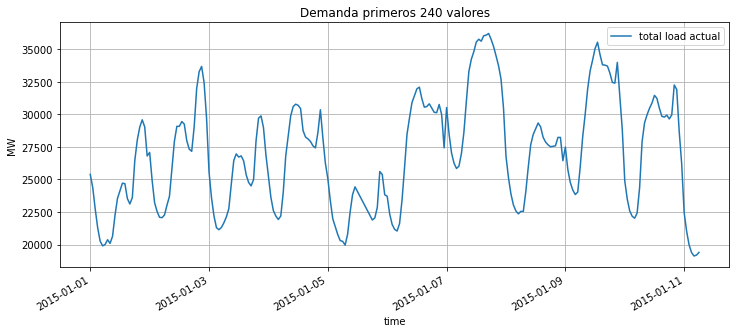

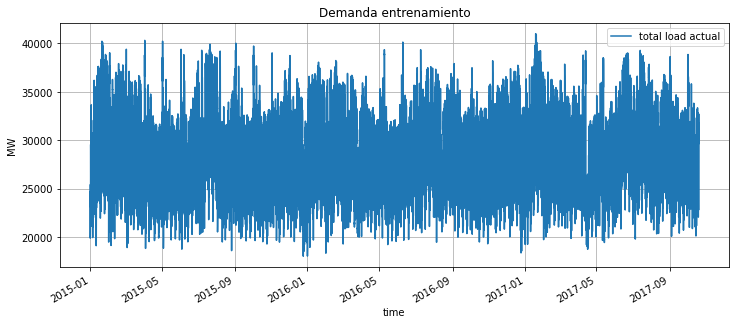

In [22]:
train_df.iloc[:240].plot(x="time", figsize=(12,5), title="Demanda primeros 240 valores", ylabel="MW", grid=True)
train_df.plot(x="time", figsize=(12,5), title="Demanda entrenamiento", ylabel="MW", grid=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'LAG')

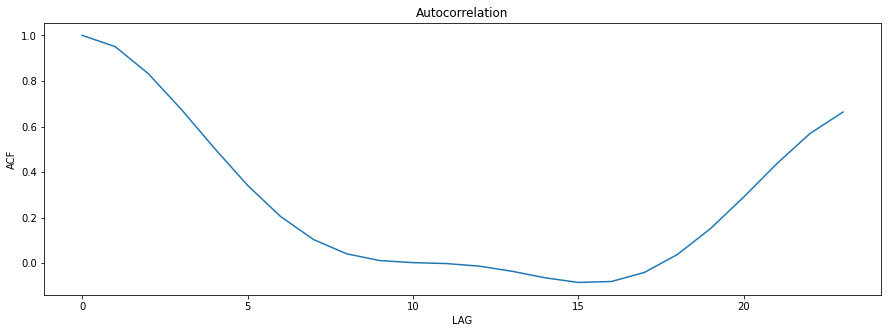

In [23]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(acf(train_values,nlags=23))
ax.set_title("Autocorrelation")
ax.set_ylabel("ACF")
ax.set_xlabel("LAG")

###Configuración del tipo de partición.

En estas celdas se configura el tipo de partición que se realiza a la data, se pueden cambiar entre 3 tipos de particiones.

####Partición

In [24]:
from itertools import product

levels = ['VL','L','M','H','VH']
sublevels = [str(k) for k in np.arange(0,7)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])
  
print(names)

['VL0', 'VL1', 'VL2', 'VL3', 'VL4', 'VL5', 'VL6', 'L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'VH0', 'VH1', 'VH2', 'VH3', 'VH4', 'VH5', 'VH6']


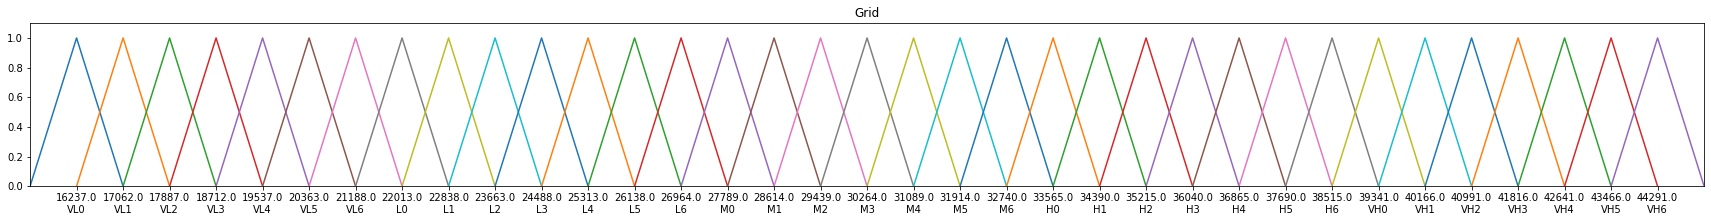

In [25]:
from pyFTS.partitioners import Grid

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[30,3])

part = Grid.GridPartitioner(data=train_values,npart=35, names=names)

part.plot(ax)

In [26]:
part

### Entrenamiento de modelos monovariables y multivariables

Seleccionando la partición de los conjuntos, entonces se realiza el entrenamiento de los modelos en las siguientes celdas, cuyos resultados de predicción son guardados en un dataframe.

In [107]:
# Modelos de una sola variable.
from pyFTS.models import hofts, pwfts
from pyFTS.common import Util

# Modelos de varias variables.
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal

# Métricas para el rendimiento de modelos
from pyFTS.benchmarks import Measures

#### Sistema de entrenamiento para series temporales difusas.

El entrenamiento de sistemas monovariables y multivariables es muy similar, por ende se realiza el desarrollo del siguiente objeto para 

In [101]:
class FuzzyTrainer():

  """ 
  Inicializador del objeto.

    data: (pd.DataFrame) Dataframe que contiene los datos a procesar.
    train_size: (float) Valor decimal que contiene el porcentaje de datos que se desea utilizar al realizar el entrenamiento del modelo.
    partition_type: (pyFTS.partitioners) tipo de partición que se le desea aplicar a la data.
    variables_list : (list) Lista que contiene las variables a añadir en caso de que se desee realizar un entrenamiento de la 
                            serie con mas de una variable.

  """

  def __init__(self, data, target, train_size, partition_type, variables_list=[]):
    self.data = data
    self.partition_type = partition_type
    self.variables_list = variables_list
    train_length = int(data.__len__() * train_size)

    # Separando los datos del conjunto de entrenamiento y prueba dependiendo del tipo de modelo que se utilice
    if variables_list.__len__() == 0:
      data_values = data[target].values
      self.train_data = data_values[:train_length]
      self.test_data = data_values[train_length:]
    else:
      self.train_data = data.iloc[:train_length]
      self.test_data = data.iloc[train_length:]


  """ 
  fit.
    model: (pyFTS.models) modelo de pyFTS que contiene el modelo que se desea entrenar. Este ya debe venir inicializado
    save_local: (bool) Valor booleano que indica si se desea guardar el modelo.
    
  """
  def fit(self, model, order, save_local=True):
    model = model(partitioner = self.partition_type, order=order)
    model.shortname += str(order)
    model.fit(self.train_data)
    if save_local:
      Util.persist_obj(model, model.shortname)
    else:
      pass
    self.model = model
    self.order = order

  def predict(self, data, dropna=False):
    predictions = list(self.model.predict(data))
    # if delete_model:
    #   del(self.model)
    if dropna or predictions.__len__() == self.test_data.__len__():
      return predictions
    else:
      k = 0
      delta_pred = self.test_data.__len__() - predictions.__len__()
      while k < delta_pred:
        predictions.insert(0, np.nan)
        k += 1
      return predictions
      

In [109]:
# Función para el cálculo de métricas de rendimiento de diversos modelos.

def regression_metrics(df, target_column):
  y_true = df[target_column].values
  df_process = df.drop(columns=['time', target_column], axis=1)
  df_metrics = pd.DataFrame()
  df_metrics['model'] = df_process.columns
  rmse_list, mape_list = [], []
  for model in df_process.columns:
    forecast_values = df_process[model].values
    RMSE = Measures.rmse(y_true, forecast_values)
    MAPE = Measures.mape(y_true, forecast_values)
    rmse_list.append(RMSE)
    mape_list.append(MAPE)

  df_metrics['RMSE'] = rmse_list
  df_metrics['MAPE'] = mape_list

  return df_metrics

In [91]:
# Inicializador del objeto de entrenamiento

data = demand_data
target = 'total load actual'
train_size = .7
partition_type = part

fuzzy_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, partition_type=partition_type)

In [97]:
# Configuración del modelo a entrenar

model = pwfts.ProbabilisticWeightedFTS
order = 3
fuzzy_trainer.fit(model=model, order=order)

In [98]:
# Predicciones del objeto entrenador

prediction_test = fuzzy_trainer.predict(test_values)

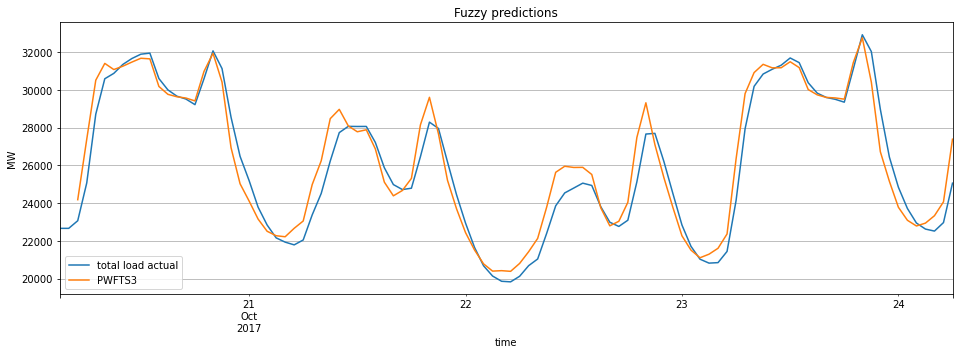

In [88]:
# Visualización gráfica del rendimiento del modelo

prediction_df['PWFTS3'] = prediction_test
prediction_df.iloc[:100].plot(x='time', ylabel='MW', title='Fuzzy predictions', grid=True, figsize=(16,5))

In [102]:
# Inicializador del objeto de entrenamiento

data = demand_data
target = 'total load actual'
train_size = .7
partition_type = part

fuzzy_single_trainer = FuzzyTrainer(data=data, target=target, train_size=train_size, partition_type=partition_type)

In [103]:
# Variables para almacenar los datos obtenidos por los modelos
models = []
prediction_df = test_df.copy()

for method in [hofts.HighOrderFTS, hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  for order in [1, 2, 3]:
    fuzzy_single_trainer.fit(model=method, order=order)
    prediction_df[fuzzy_single_trainer.model.shortname] = fuzzy_single_trainer.predict(test_values)

In [123]:
prediction_df.head()

,time,total load actual,HOFTS1,HOFTS2,HOFTS3,WHOFTS1,WHOFTS2,WHOFTS3,PWFTS1,PWFTS2,PWFTS3
24511,2017-10-20 03:00:00+02:00,22658.0,NaN,NaN,NaN,NaN,NaN,NaN,23043.544165,NaN,NaN
24512,2017-10-20 04:00:00+02:00,22658.0,25877.185524,NaN,NaN,22836.371543,NaN,NaN,23043.544165,23227.826246,NaN
24513,2017-10-20 05:00:00+02:00,23062.0,25877.185524,23663.082857,NaN,22836.371543,22989.435268,NaN,23412.178541,23754.443016,24175.794417
24514,2017-10-20 06:00:00+02:00,25065.0,25588.389524,24694.497143,24694.497143,23584.028508,24306.253665,24597.487981,25289.288971,27088.248993,27381.764698
24515,2017-10-20 07:00:00+02:00,28707.0,26757.325714,26757.325714,26977.673312,25161.821735,26734.054072,26907.318032,28632.887518,30509.966567,30506.547010


In [136]:
prediction_df2 = prediction_df.dropna()
metrics_df = regression_metrics(prediction_df2, 'total load actual')
metrics_df.sort_values('MAPE')

,model,RMSE,MAPE
6,PWFTS1,279.556142,0.873876
5,WHOFTS3,926.525288,2.335932
7,PWFTS2,945.078502,2.467776
4,WHOFTS2,989.392202,2.540805
8,PWFTS3,1086.048942,2.838911
2,HOFTS3,1074.764968,2.944514
1,HOFTS2,1256.882691,3.612588
3,WHOFTS1,1447.590564,3.893060
0,HOFTS1,2309.563704,6.903071


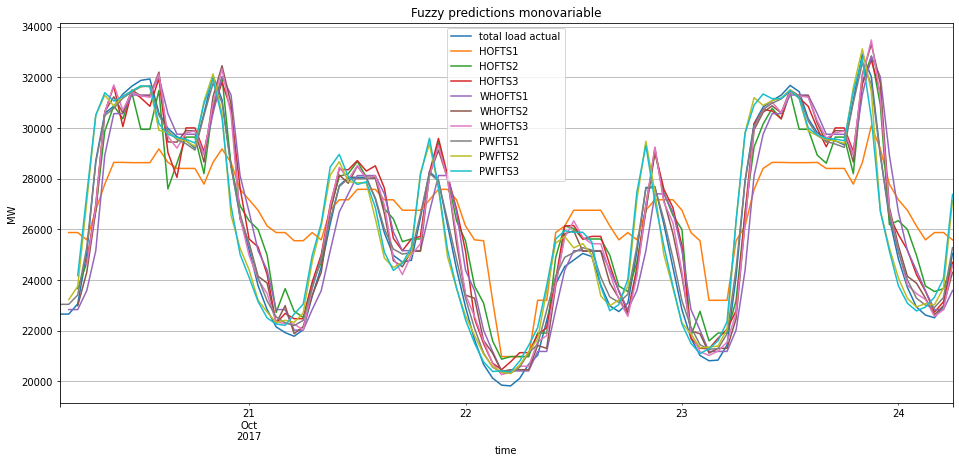

In [118]:
prediction_df.iloc[:100].plot(x='time', ylabel='MW', title='Fuzzy predictions monovariable', grid=True, figsize=(16,7))

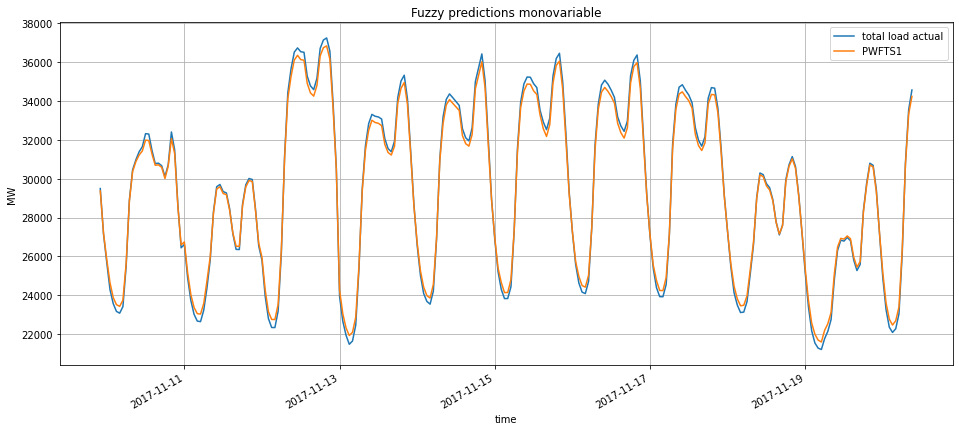

In [122]:
prediction_df[['time','total load actual', 'PWFTS1']].iloc[500:750].plot(x='time', ylabel='MW', title='Fuzzy predictions monovariable', grid=True, figsize=(16,7))

###Modelos multivariables

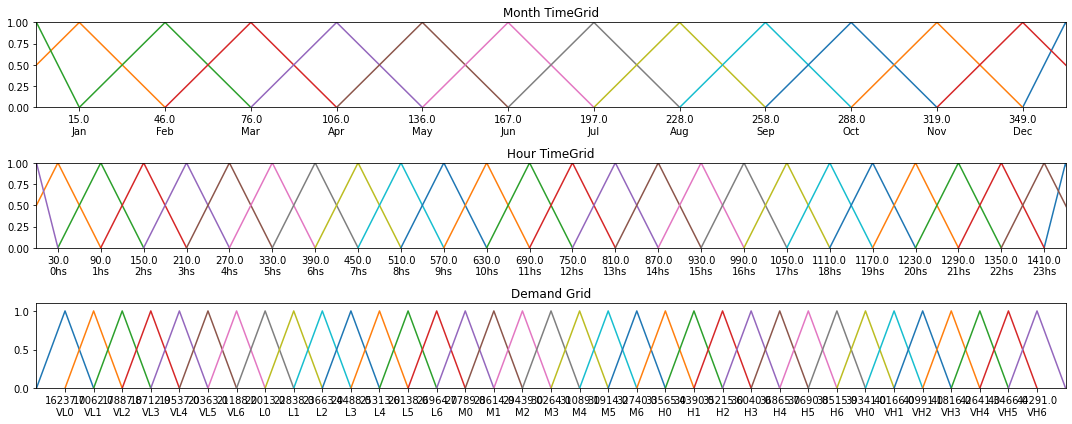

In [124]:
from pyFTS.models.seasonal.common import DateTime

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[15,6])


sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Feb','Mar','Apr','May',
                                                      'Jun','Jul', 'Aug','Sep','Oct',
                                                      'Nov','Dec']}

vmonth = variable.Variable("Month", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train_df, partitioner_specific=sp)

vmonth.partitioner.plot(ax[0])


sp = {'seasonality': DateTime.minute_of_day, 'names': [str(k)+'hs' for k in range(0,24)]}

vhour = variable.Variable("Hour", data_label="time", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_df, partitioner_specific=sp)

vhour.partitioner.plot(ax[1])

vavg = variable.Variable("Demand", data_label="total load actual", alias='dem',
                         partitioner=Grid.GridPartitioner, npart=35, partitioner_specific={'names': names},  
                         data=train_df) 

vavg.partitioner.plot(ax[2])

plt.tight_layout()

In [140]:
from pyFTS.models.multivariate import mvfts, wmvfts, granular

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])

parameters = [
    {},{},
    {'order':2, 'knn': 1},
    {'order':2, 'knn': 2},
    {'order':2, 'knn': 3},
]

# Dataframe con los valores de las predicciones de los modelos multivariables
predictions_multi_df = test_df.copy()

# ax.plot(test_values[:100],label='demand')

for ct, method in enumerate([mvfts.MVFTS, wmvfts.WeightedMVFTS, 
                             granular.GranularWMVFTS,granular.GranularWMVFTS,granular.GranularWMVFTS]):
  try:
    model = method(**parameters[ct])
    model.shortname += str(ct)
    model.append_variable(vmonth)
    model.append_variable(vhour)
    model.append_variable(vavg)
    model.target_variable = vavg
    model.fit(train_df)

    models.append(model.shortname)

    Util.persist_obj(model, model.shortname)

    # forecasts = list(model.predict(test_df.iloc[:100]))
    forecasts = list(model.predict(test_df))
    print(model.shortname + ":" , forecasts.__len__())

    delta_predictions = test_df.__len__() - forecasts.__len__()

    if delta_predictions > 0:
      k = 0
      while k < delta_predictions:
        forecasts.insert(0, np.nan)
        k += 1

    # ax.plot(forecasts[:100], label=model.shortname)

    predictions_multi_df[model.shortname] = forecasts
    prediction_df[model.shortname] = forecasts
    del(model)

  except Exception as ex:
    print(key, method, parameters[ct2])
    print(ex)


# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

MVFTS0: 10506
WeightedMVFTS1: 10506
File FIG-FTS2 could not be saved due exception maximum recursion depth exceeded in comparison
FIG-FTS2: 10504
File FIG-FTS3 could not be saved due exception maximum recursion depth exceeded in comparison
FIG-FTS3: 10504
File FIG-FTS4 could not be saved due exception maximum recursion depth exceeded in comparison
FIG-FTS4: 10504


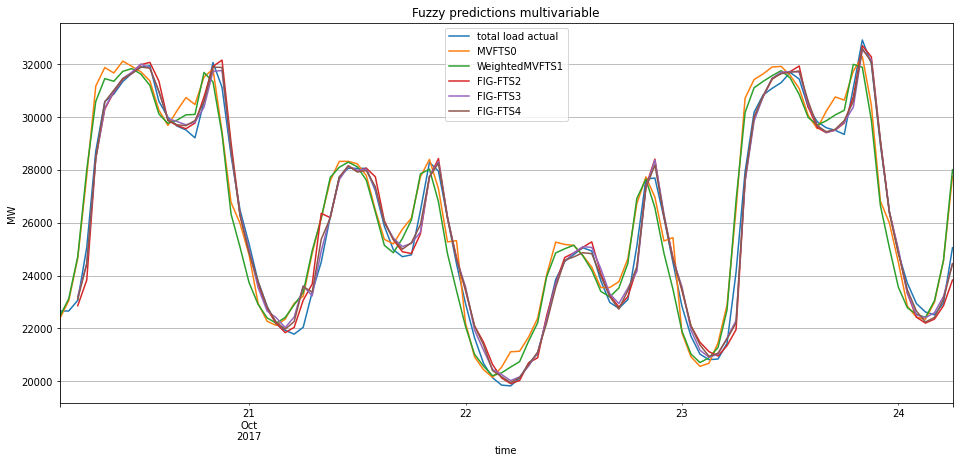

In [135]:
predictions_multi_df.iloc[:100].plot(x='time', ylabel='MW', title='Fuzzy predictions multivariable', grid=True, figsize=(16,7))

In [137]:
multi_metrics = regression_metrics(predictions_multi_df.dropna(), 'total load actual')
multi_metrics.sort_values('MAPE')

,model,RMSE,MAPE
3,FIG-FTS3,657.438102,1.542289
4,FIG-FTS4,670.168114,1.585739
2,FIG-FTS2,707.455581,1.707897
1,WeightedMVFTS1,1258.927305,3.482089
0,MVFTS0,1307.158328,3.608678


In [141]:
total_metrics = regression_metrics(prediction_df.dropna(), 'total load actual')
total_metrics.sort_values('MAPE')

,model,RMSE,MAPE
6,PWFTS1,279.556142,0.873876
12,FIG-FTS3,657.457209,1.542254
13,FIG-FTS4,670.459811,1.585928
11,FIG-FTS2,705.980860,1.702455
5,WHOFTS3,926.525288,2.335932
7,PWFTS2,945.078502,2.467776
4,WHOFTS2,989.392202,2.540805
8,PWFTS3,1086.048942,2.838911
2,HOFTS3,1074.764968,2.944514
10,WeightedMVFTS1,1258.884410,3.481740


###Rankeo de Modelos

In [126]:
from pyFTS.benchmarks import Measures

rows = []
for file in models:
  try:
    model = Util.load_obj(file)

    row = [model.shortname, model.order,len(model)]

    if model.is_multivariate:
      rmse,_,_ = Measures.get_point_statistics(test_df, model)
      # mape = Measures.mape(test_values, model.predict(test_df))
      row.append(rmse)
      # row.append(mape)
    else:
      rmse,_,_ = Measures.get_point_statistics(test_values, model)
      row.append(rmse)

    rows.append(row)
  except:
    pass

pd.DataFrame(rows,columns=["Model","Order","Size","RMSE"]).sort_values(["RMSE"])

,Model,Order,Size,RMSE
1,WeightedMVFTS1,1,5496,623.03
0,MVFTS0,1,5496,727.76


In [ ]:
from pyFTS.benchmarks import Measures

rows = []
for file in models:
  try:
    model = Util.load_obj(file)

    row = [model.shortname, model.order,len(model)]

    if model.is_multivariate:
      rmse,_,_ = Measures.get_point_statistics(test_df, model)
      mape = Measures.mape(test_values, model.predict(test_df))
      row.append(rmse)
      row.append(mape)
    else:
      rmse,_,_ = Measures.get_point_statistics(test_values, model)
      mape = Measures.mape(test_values, model.predict(test_values))
      # print(file  + ": ", mape)
      row.append(rmse)
      # row.append(mape)

    rows.append(row)
  except:
    pass

# pd.DataFrame(rows,columns=["Model","Order","Size","RMSE","MAPE"]).sort_values(["RMSE"])
pd.DataFrame(rows,columns=["Model","Order","Size","RMSE"]).sort_values(["RMSE"])

PWFTS1:  0.8740944323209475


,Model,Order,Size,RMSE
0,PWFTS1,1,30,1429.35


####Prediccion para las siguientes 48 horas

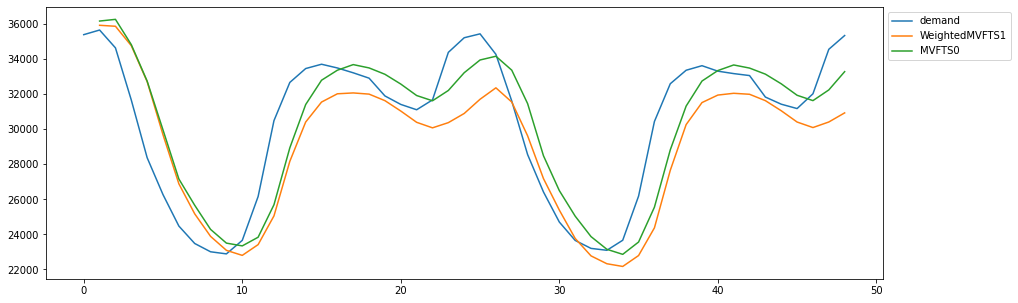

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test_values[:49],label='demand')

generator = lambda x : x + pd.to_timedelta(1, unit='h') 

for file in ['WeightedMVFTS1', 'MVFTS0']:
  try:
    model = Util.load_obj(file)

    forecasts = model.predict(test_df.iloc[:1], steps_ahead=48, 
                              generators={'time': generator})

    for k in np.arange(model.order):
      forecasts.insert(0,None)

    ax.plot(forecasts, label=model.shortname)
  except Exception as ex:
    print(ex)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [ ]:
test_df.iloc[:1]

,time,total load actual
16393,2016-11-15 19:00:00+01:00,35396.0


### Modelos de machine learning aplicados a series difusas.

De manera similar a la seccion anterior, tras la conversión de los datos para la obtención de las series temporales difusas, entonces se aplican los mismos modelos para la predicción de la demanda en este dominio, ademas de hacerse la operación inversa para la obtención de la predicción en el dominio inicial.